In [1]:
import h5py
import pylab as pl
import numpy as np
import scipy.stats as sp
import matplotlib as mpl
import networkx
import progressbar

In [2]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

In [3]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)
sim = h5py.File('/data/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/data/cielo/simulations/LG1/LG1_tree.dat')

In [4]:
Slist = h5py.File('SatelliteList_V2_withAngles_n500_Pairs.h5', 'r')
Satellites = Slist['SatelliteList'][()]
Centrals = Slist['SatelliteCentral'][()]
sgroup = Slist['inGroup']

In [5]:
HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

In [6]:
#ok, now the serialized version of the get particles for each Satellite, lets see.
TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()] # need this first
I= np.identity(3) # and this

In [7]:
def getAllLastP(fofID, centralID):
    """
    get position, masses and abundances of all particles that in past snapshot belong to a given subhalo,
    and a z=0 are located at athe maximum distance of 600 kpc to the subhalo,
    rotated by the velocity and the vector to the centre.
    """
    uniqueID = int(128*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree = get_main_branch_unique_ids(stree, str(uniqueID))
    
    #firts find all the particleIDs that once belong to the subgroup
    Idlist = []

    for mm in mtree[1:]: # ignore the first one
        snap, idd = split_unique_id(int(mm))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            Idlist.extend(list(tempIds))

    Idlist = np.array(Idlist)
    Idlist = np.unique(Idlist) # remove duplicates
    
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    # lets remove the ones that are not part of the group today.
    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]

    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]
    
    #now lets cut at  a certain distance
    #distance = 600 # distance in ckpc
    distance = 200 
    
    posGal = sim['SnapNumber_128/SubGroups/SubGroupPos'][fofID]
    posCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][centralID]

    LostCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_]
    
    dx, dy, dz = LostCoord[:,0]-posGal[0], LostCoord[:,1]-posGal[1], LostCoord[:,2]-posGal[2]
    distToC = np.sqrt(dx**2+dy**2+dz**2)

    icut = np.where(distToC<distance)[0]
    IndexT_near = IndexT_[icut] # this is the final list of particles ids
    
    # ok, lest see velocity and stuff
    velCen = sim['SnapNumber_128/SubGroups/SubGroupVel'][centralID]
    velSat = sim['SnapNumber_128/SubGroups/SubGroupVel'][fofID]

    velRep = velSat - velCen
    
    GasMasses = sim['SnapNumber_128/PartType0/Masses'][IndexT_near]
    GassAbundances = sim['SnapNumber_128/PartType0/Abundances'][IndexT_near]
    
    NearCoord = sim['SnapNumber_128/PartType0/Coordinates'][IndexT_near]

    # first lets re-define coordinates in a galactocentric scheme.
    X, Y, Z = NearCoord[:,0] - posGal[0], NearCoord[:,1] - posGal[1], NearCoord[:,2] - posGal[2]
    xC, yC, zC = posCen[0] - posGal[0], posCen[1] - posGal[1], posCen[2] - posGal[2] # the direction of the centre from the galaxy
    
    # now define normalized vectors, for velocity and centre directions
    velX, velY, velZ = velRep[0], velRep[1], velRep[2]
    Vel = np.sqrt(velX**2 + velY**2 + velZ**2)
    Cen = np.sqrt(xC**2 + yC**2 + zC**2)

    velx, vely, velz = velX/Vel, velY/Vel, velZ/Vel
    xc, yc, zc = xC/Cen, yC/Cen, zC/Cen
    
    # Then, the rotations matrix are, for velocity
    faV = (1-velx)/(vely**2+ velz**2)
    VV = np.array([[0, vely, velz], [-vely, 0, 0], [-velz, 0, 0]])
    VV2 = np.matmul(VV, VV)

    RV = I + VV + VV2*faV
    
    # and for the direction to the centre
    faC = (1-xc)/(yc**2+zc**2)
    CC = np.array([[0, yc, zc], [-yc, 0, 0], [-zc, 0, 0]])
    CC2 = np.matmul(CC, CC)

    RC = I + CC + CC2*faC
    
    # lets calculate the rotated coordinates
    xRv, yRv, zRv = [], [], []
    xRc, yRc, zRc = [], [], []

    for x, y, z in zip(X, Y, Z):
        dV = np.matmul(RV, np.array([x, y, z]))
        dC = np.matmul(RC, np.array([x, y, z]))
    
        xRv.append(dV[0])
        yRv.append(dV[1])
        zRv.append(dV[2])
    
        xRc.append(dC[0])
        yRc.append(dC[1])
        zRc.append(dC[2])
    
    xRv, yRv, zRv = np.array(xRv), np.array(yRv), np.array(zRv)
    xRc, yRc, zRc = np.array(xRc), np.array(yRc), np.array(zRc)
        
    # now, I only need one number, the cos stuff
    cosC = xRc/np.sqrt(xRc**2.+yRc**2.+zRc**2.)
    cosV = xRv/np.sqrt(xRv**2.+yRv**2.+zRv**2.)
    
    # and return the 2 sets of rotated positions, masses and abundances
    return cosV, cosC, GasMasses, GassAbundances

Text(0.5, 0, 'r/r_200')

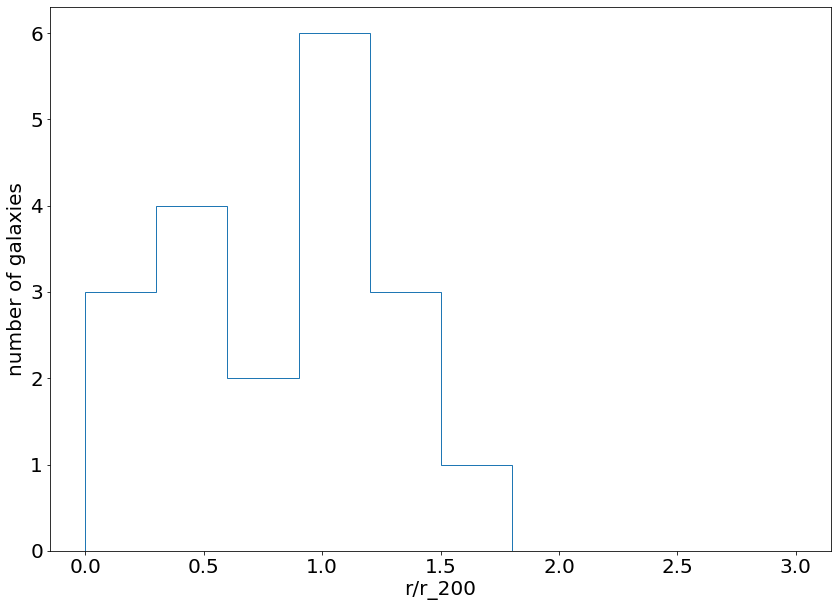

In [8]:
# lets test somo clean up by separation.
R200, GalCen, GroCen = [], [], []

for ss, cc in zip(Satellites, Centrals):
    group = sim['SnapNumber_128/SubGroups/GroupNumber'][cc]
    r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    galCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][ss]
    groCen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cc]
    
    R200.append(r200)
    GalCen.append(galCen)
    GroCen.append(groCen)

R200, GalCen, GroCen = np.array(R200), np.array(GalCen), np.array(GroCen)

iz = np.where(R200>0.)

Satellites = Satellites[iz]
Centrals = Centrals[iz]
sgroup = sgroup[iz]

R200, GalCen, GroCen = R200[iz], GalCen[iz], GroCen[iz] 

sep = GalCen - GroCen
dist = np.sqrt(sep[:,0]**2+sep[:,1]**2+sep[:,2]**2)
dist = dist/R200

# Satellites = Slist['SatelliteList'][()]
# Centrals = Slist['SatelliteCentral'][()]
# CosCen = Slist['CosCen'][()]
# CosVel = Slist['CosVel'][()]
# LzL = Slist['LZ_L'][()]

pl.figure(figsize=(14, 10))

pl.hist(dist, histtype='step', range=(0,3))
pl.ylabel('number of galaxies')
pl.xlabel('r/r_200')

In [9]:
ir = np.where(dist>0.5)

Satellites = Satellites[ir]
Centrals = Centrals[ir]
sgroup = sgroup[ir]

Satellites.size

14

In [10]:
# lets separate by pairs

i1 = np.where(sgroup)
i2 = np.where(sgroup==False)

sat1, cent1 = Satellites[i1], Centrals[i1]
sat2, cent2 = Satellites[i2], Centrals[i2]

sat1.size, sat2.size

(6, 8)

In [11]:
# in pairs
size = sat1.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_1, CosRc_1, GASMasses_1, GASAbundances_1 = [], [], [], []
StarMass_1 = []

for ff, cc in zip(sat1, cent1):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    
    CosRv_1.extend(list(cosRv))
    CosRc_1.extend(list(cosRc))
    GASMasses_1.extend(list(GasMasses))
    GASAbundances_1.extend(list(GasAbundances))
    
    # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    
    StarMass_1.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_1, CosRc_1, GASMasses_1, GASAbundances_1 = np.array(CosRv_1), np.array(CosRc_1), np.array(GASMasses_1), np.array(GASAbundances_1)
StarMass_1 = np.array(StarMass_1)
passs

100% (6 of 6) |##########################| Elapsed Time: 0:02:51 ETA:  00:00:00

6

In [12]:
 # high cos central
size = sat2.size
# size = 100

bar = progressbar.ProgressBar(max_value=size)
C, passs = 0, 0

CosRv_2, CosRc_2, GASMasses_2, GASAbundances_2 = [], [], [], []
StarMass_2 = []

for ff, cc in zip(sat2, cent2):
    try:
        cosRv, cosRc, GasMasses, GasAbundances = getAllLastP(ff, cc)
        passs += 1
    except:
        C += 1
        continue
    CosRv_2.extend(list(cosRv))
    CosRc_2.extend(list(cosRc))
    GASMasses_2.extend(list(GasMasses))
    
    GASAbundances_2.extend(list(GasAbundances))
    
     # and star masses
    offst = sim['SnapNumber_128/SubGroups/PartType4/Offsets'][ff].astype('int')
    STMass = sim['SnapNumber_128/PartType4/Masses'][offst[0]:offst[1]]
    STM = np.sum(STMass)
    StarMass_2.extend([STM]*cosRv.size)
    
    C += 1
    bar.update(C)
    
CosRv_2, CosRc_2, GASMasses_2, GASAbundances_2 = np.array(CosRv_2), np.array(CosRc_2), np.array(GASMasses_2), np.array(GASAbundances_2)
StarMass_2 = np.array(StarMass_2)

passs

100% (8 of 8) |##########################| Elapsed Time: 0:00:27 ETA:  00:00:00

8

Text(0, 0.5, 'Gas Mass/Stellar Mass')

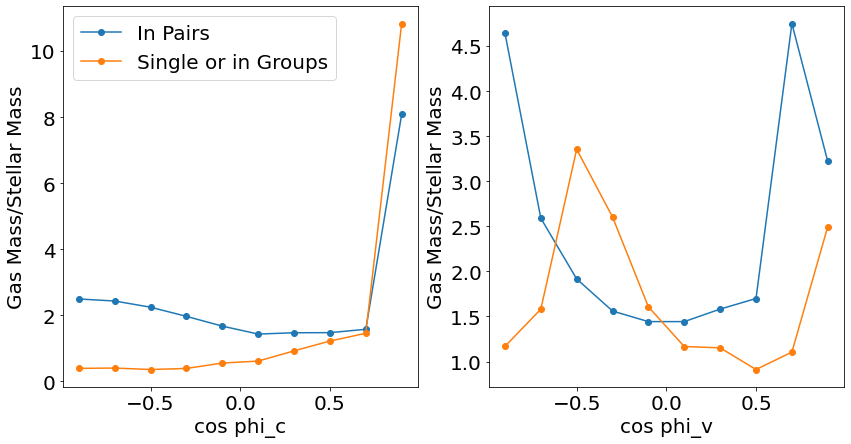

In [13]:
# a little cleanup

i1 = np.where(StarMass_1>0)
CosRc_1, CosRv_1, GASMasses_1, StarMass_1 = CosRc_1[i1], CosRv_1[i1], GASMasses_1[i1], StarMass_1[i1]

i2 = np.where(StarMass_2>0)
CosRc_2, CosRv_2, GASMasses_2, StarMass_2 = CosRc_2[i2], CosRv_2[i2], GASMasses_2[i2], StarMass_2[i2]


pl.figure(figsize=(14, 7))

sumC1, binsC1, zipC1 = sp.binned_statistic(CosRc_1, GASMasses_1/StarMass_1, statistic='sum', bins=10, range=(-1.,1.))
sumC2, binsC2, zipC2 = sp.binned_statistic(CosRc_2, GASMasses_2/StarMass_2, statistic='sum', bins=10, range=(-1.,1.))

sumV1, binsV1, zipV1 = sp.binned_statistic(CosRv_1, GASMasses_1/StarMass_1, statistic='sum', bins=10, range=(-1.,1.))
sumV2, binsV2, zipV2 = sp.binned_statistic(CosRv_2, GASMasses_2/StarMass_2, statistic='sum', bins=10, range=(-1.,1.))

# bins should be the same
x_x = .5*(binsV2[:-1]+binsV2[1:])

pl.subplot(1, 2, 1)

pl.plot(x_x, sumC1, marker='o', label='In Pairs')
pl.plot(x_x, sumC2, marker='o', label='Single or in Groups')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
pl.ylabel('Gas Mass/Stellar Mass')

pl.subplot(1, 2, 2)

pl.plot(x_x, sumV1, marker='o', label='In Groups')
pl.plot(x_x, sumV2, marker='o', label='Single or in Groups')

pl.xlabel('cos phi_v')
pl.ylabel('Gas Mass/Stellar Mass')

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


Text(0, 0.5, '[O/Fe]')

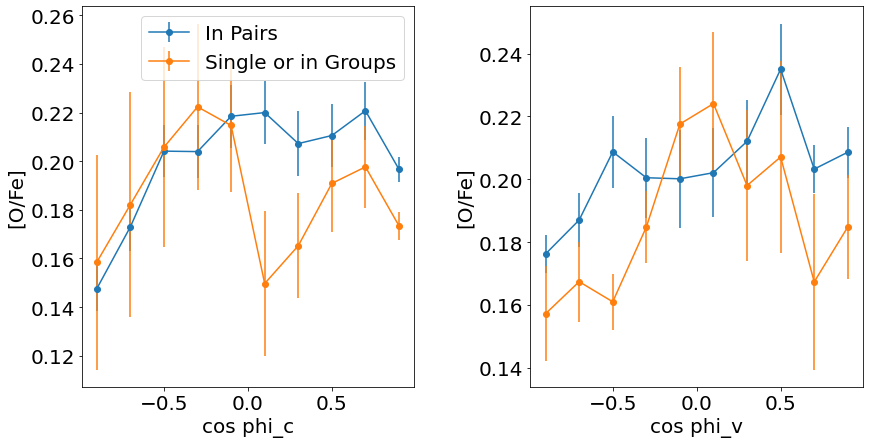

In [14]:
# cos V for both

pl.figure(figsize=(14, 7))
pl.subplots_adjust(wspace=0.35)
# sumC1_V, binsC1_V, zipC1_V = sp.binned_statistic(CosRc_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# sumC2_V, binsC2_V, zipC2_V = sp.binned_statistic(CosRc_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# sumV1_V, binsV1_V, zipV1_V = sp.binned_statistic(CosRv_V1, GASAbundances_V1[:,5]/StarMass_V1, statistic='sum', bins=7, range=(-1.,1.))
# sumV2_V, binsV2_V, zipV2_V = sp.binned_statistic(CosRv_V2, GASAbundances_V2[:,5]/StarMass_V2, statistic='sum', bins=7, range=(-1.,1.))

# data_V1 = GASAbundances_V1[:,5]
# data_V2 = GASAbundances_V2[:,5]
# weight_V1 = 1./StarMass_V1
# weight_V2 = 1./StarMass_V2

# data_1 = temp2_1
# data_2 = temp2_2
# weight_1 = np.ones(temp_1.size)
# weight_2 = np.ones(temp_2.size)

data_1 = np.log10((GASAbundances_1[:,3]/OMass)/(GASAbundances_1[:,4]/FeMass)) - NoNfe_sun
# # # data_1 = data_1 - temp_1
# # data_1 = temp_1
i_1 = np.where((np.isinf(data_1)==False) & (np.isnan(data_1)==False))
data_1 = data_1[i_1]
CosRc_1 = CosRc_1[i_1]
CosRv_1 = CosRv_1[i_1]
weight_1 = np.ones(data_1.size)

data_2 = np.log10((GASAbundances_2[:,3]/OMass)/(GASAbundances_2[:,4]/FeMass)) - NoNfe_sun
# # data_2 = data_2 - temp_2
# # data_2 = temp_2
i_2 = np.where((np.isinf(data_2)==False) & (np.isnan(data_2)==False))
data_2 = data_2[i_2]
CosRc_2 = CosRc_2[i_2]
CosRv_2 = CosRv_2[i_2]
weight_2 = np.ones(data_2.size)


# weight_1 = np.log10((GASAbundances_1[:,4]/FeMass)/(GASAbundances_1[:,6]/HMass)) - NfeNhe_sun
# weight_1 = (GASAbundances_1[:,4]/FeMass)/(GASAbundances_1[:,6]/HMass)
# weight_1 = temp_1
# i_1 = np.where((np.isinf(weight_1)==False) & (np.isnan(weight_1)==False))
# weight_1 = weight_1[i_1]
# miwe_1 = weight_1.min()
# weight_1 = weight_1 - miwe_1

# CosRc_1 = CosRc_1[i_1]
# CosRv_1 = CosRv_1[i_1]

# data_1 = temp2_1[i_1]

# weight_2 = np.log10((GASAbundances_2[:,4]/FeMass)/(GASAbundances_2[:,6]/HMass)) - NfeNhe_sun
# weight_2 = (GASAbundances_2[:,4]/FeMass)/(GASAbundances_2[:,6]/HMass)
# weight_2 = temp_2
# i_2 = np.where((np.isinf(weight_2)==False) & (np.isnan(weight_2)==False))

# weight_2 = weight_2[i_2]
# miwe_2 = weight_2.min()
# weight_2 = weight_2 - miwe_2 # one will weight 0, but, well, *shrughs*

# CosRc_2 = CosRc_2[i_2]
# CosRv_2 = CosRv_2[i_2]

# data_2 = temp2_2[i_2]

sumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1*weight_1, statistic='sum', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2*weight_2, statistic='sum', bins=10, range=(-1.,1.))

WsumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, weight_1, statistic='sum', bins=10, range=(-1.,1.))
WsumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, weight_2, statistic='sum', bins=10, range=(-1.,1.))
WsumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, weight_1, statistic='sum', bins=10, range=(-1.,1.))
WsumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, weight_2, statistic='sum', bins=10, range=(-1.,1.))

sumC_1 = sumC_1/WsumC_1
sumC_2 = sumC_2/WsumC_2
sumV_1 = sumV_1/WsumV_1
sumV_2 = sumV_2/WsumV_2

sumC_1e = sumC_1[zipC_1-1]
sumC_2e = sumC_2[zipC_2-1]
sumV_1e = sumV_1[zipV_1-1]
sumV_2e = sumV_2[zipV_2-1]

stdC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, ((data_1-sumC_1e)*weight_1)**2., statistic='sum', bins=10, range=(-1.,1.))
stdC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, ((data_2-sumC_2e)*weight_2)**2., statistic='sum', bins=10, range=(-1.,1.))
stdV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, ((data_1-sumV_1e)*weight_1)**2., statistic='sum', bins=10, range=(-1.,1.))
stdV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, ((data_2-sumV_2e)*weight_2)**2., statistic='sum', bins=10, range=(-1.,1.))

numbC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1, statistic='count', bins=10, range=(-1.,1.))
numbC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2, statistic='count', bins=10, range=(-1.,1.))
numbV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1, statistic='count', bins=10, range=(-1.,1.))
numbV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2, statistic='count', bins=10, range=(-1.,1.))

errC_1 = np.sqrt(numbC_1/((numbC_1-1.)*WsumC_1**2.)*stdC_1)
errC_2 = np.sqrt(numbC_2/((numbC_2-1.)*WsumC_2**2.)*stdC_2)
errV_1 = np.sqrt(numbV_1/((numbV_1-1.)*WsumV_1**2.)*stdV_1)
errV_2 = np.sqrt(numbV_2/((numbV_2-1.)*WsumV_2**2.)*stdV_2)


sumC_1, binsC_1, zipC_1 = sp.binned_statistic(CosRc_1, data_1, statistic='median', bins=10, range=(-1.,1.))
sumC_2, binsC_2, zipC_2 = sp.binned_statistic(CosRc_2, data_2, statistic='median', bins=10, range=(-1.,1.))
sumV_1, binsV_1, zipV_1 = sp.binned_statistic(CosRv_1, data_1, statistic='median', bins=10, range=(-1.,1.))
sumV_2, binsV_2, zipV_2 = sp.binned_statistic(CosRv_2, data_2, statistic='median', bins=10, range=(-1.,1.))

errC_1 = errC_1 * np.sqrt(np.pi/2.)
errC_2 = errC_2 * np.sqrt(np.pi/2.)
errV_1 = errV_1 * np.sqrt(np.pi/2.)
errV_2 = errV_2 * np.sqrt(np.pi/2.)


# bins should be the same
x_x = .5*(binsV_2[:-1]+binsV_2[1:])

pl.subplot(1, 2, 1)

# pl.plot(x_x, sumC1_V, marker='o', label='cos theta_v<0.5')
# pl.plot(x_x, sumC2_V, marker='o', label='cos theta_v>0.5')

pl.errorbar(x_x, sumC_1, yerr=errC_1, marker='o', label='In Pairs')
pl.errorbar(x_x, sumC_2, yerr=errC_2, marker='o', label='Single or in Groups')

pl.legend(loc='best')

pl.xlabel('cos phi_c')
# pl.ylabel('Time since stripping/Gyrs')
pl.ylabel('[O/Fe]')
# pl.ylabel('Temperature/K')

pl.subplot(1, 2, 2)

# pl.plot(x_x, sumV1_V, marker='o', label='cos theta<0.5')
# pl.plot(x_x, sumV2_V, marker='o', label='cos theta>0.5')

pl.errorbar(x_x, sumV_1, yerr=errV_1, marker='o', label='In Pairs')
pl.errorbar(x_x, sumV_2, yerr=errV_2, marker='o', label='Single or in Groups')

pl.xlabel('cos phi_v')
# pl.ylabel('Time since stripping/Gyrs')
pl.ylabel('[O/Fe]')
# pl.ylabel('Temperature/K')
